# Calibration

Modern integrated circuits, or chips, are manufactured using a complex process where the chips are essentially printed onto a silicon wafer (see this **[video](https://www.youtube.com/watch?v=g8Qav3vIv9s)** for an overview of the process). Each wafer contains many chips (e.g. a wafer with 300mm diameter fits several hundred laptop grade microprocessors). The chips on a finished wafer are tested to identify which are good and which are faulty. The yield of a wafer is determined by the fraction of good chips. To maximize the yield, semiconductor manufacturers are interested in identifying and correcting the causes of the faulty chips (e.g. wrong settings in one of processing steps). Some causes can be identified by visual inspection of patterns in a wafer maps, showing which chips are good and which are faulty.

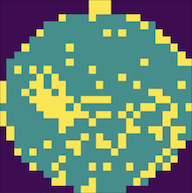

In this assignment you will work with wafer map data from a semiconductor manufacturing process. Your task will be to develop a calibrated classifier for identifying patterns of faulty chips on a finished wafer. Identifying such patterns can help with optimizing the manufacturing process parameters for the following wafers.

#### Deliverable

Throughout this notebook you will find cells starting with `#TODO` and `# // BEGIN_TODO`.

- Fill in all these TODO cells. The `#TODO` cells are meant to guide you (you are strongly encouraged to fill these in!), while the `# // BEGIN_TODO` _answer cells_ will be graded.
- Answer cells start and end with tags, `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]`, for example. Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- Be careful when importing additional libraries. The code for of your answers will be evaluated automatically and we cannot guarantee that any additional libraries will be available in that environment. Please check the Momotor output on Canvas after submitting the assignment, you should be able to see if all your code executed without errors. If in doubt, please ask your instructor.
- You can add arbitrary many code and text cells between the `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags to make your code nicely readable.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

At the end, deliver the filled in **and executed** `.ipynb` file by submitting it to the corresponding assignment on Canvas. You may submit as many times as you like before the deadline. The last submission counts.

> **IMPORTANT:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = 7
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [2]:
#// BEGIN_TODO [AUTHOR]
group_number = 24
name_student1 = "Mert Gursu Gokcen"
id_student1 = "1924850"
name_student2 = "Devansh Mishra"
id_student2 = "1932551"
#// END_TODO [AUTHOR]

## Import libraries

Later, the code in your answer cells will be evaluated in an environment with several typical data science libraries installed, including pandas, numpy, matplotlib, sklearn. You are free to use them.

> **IMPORTANT:** Please import any additional libraries inside your answer cells (otherwise your code may crash during evaluation).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

## Load the data

The data resides in the `./data/wafer.pkl` pickle file. It is based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

In [4]:
with open('data/wafer.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)


`X` contains wafer maps and `y` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

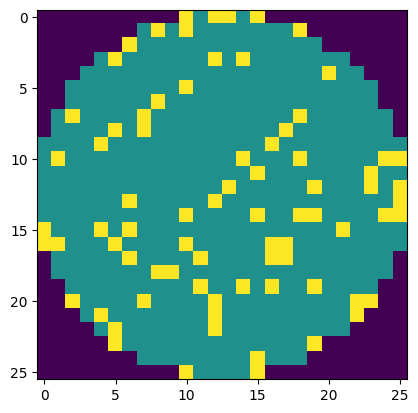

In [5]:
plt.imshow(X_train[0]);

The wafer maps were labeled by human experts according to bad chip patterns, where each label is an integer:

- 0: No pattern
- 1: Center
- 2: Donut
- 3: Edge-local
- 4: Edge-ring
- 5: Local
- 6: Near-full
- 7: Random
- 8: Scratch

An example of the wafer map for each pattern is shown below. Note that not all patterns may be present in this particular data set. 

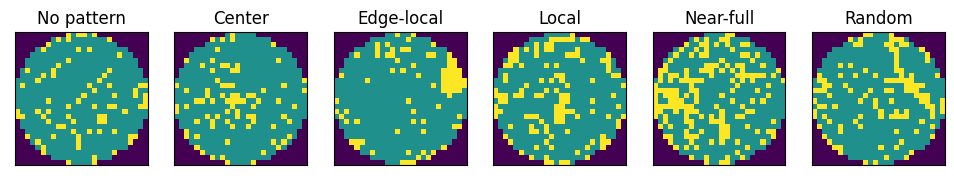

In [6]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Center", "Donut", "Edge-local", "Edge-ring", "Local", "Near-full", "Random", "Scratch"]
fig, axes = plt.subplots(1,len(unique_classes), figsize = (12,5))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

## Train a classifier

In this part you will implement a classifier, which will be used later for evaluating your calibration method.

First, start by exploring the data. Remember, you can add as many code and markdown cells as you like.

In [7]:
# TODO: Explore the data
print("EDA for train data:")
print(f'The number of wafer maps in training data is {X_train.shape[0]} with a resolution of {X_train.shape[1]}x{X_train.shape[2]} pixels')
print(f'The number of labels for wafer maps is {y_train.shape[0]}')
print(f'The target values in our training data are the following: {np.unique(y_train)} \n')


print("EDA for test data:")
print(f'The number of wafer maps in training data is {X_test.shape[0]} with a resolution of {X_test.shape[1]}x{X_test.shape[2]} pixels')
print(f'The number of labels for wafer maps is {y_test.shape[0]}')

print(f'The target values in our training data are the following: {np.unique(y_test)} \n')


EDA for train data:
The number of wafer maps in training data is 4160 with a resolution of 26x26 pixels
The number of labels for wafer maps is 4160
The target values in our training data are the following: [0 1 3 5 6 7] 

EDA for test data:
The number of wafer maps in training data is 2065 with a resolution of 26x26 pixels
The number of labels for wafer maps is 2065
The target values in our training data are the following: [0 1 3 5 6 7] 



In [8]:
print(np.isnan(X_train).any())
print(np.isnan(X_train).any(axis=1).any())
print(np.isnan(X_train).any(axis=2).any())
print(np.isnan(y_train).any())
print(np.isnan(X_test).any())
print(np.isnan(X_test).any(axis=1).any())
print(np.isnan(X_test).any(axis=2).any())
print(np.isnan(y_test).any())

False
False
False
False
False
False
False
False


In [9]:
print(np.unique(y_train))
print(np.unique(y_test))

[0 1 3 5 6 7]
[0 1 3 5 6 7]


In the first part of this assignment the aim is to identify whether the wafer map contains any known patterns or not. We therefore treat it as a binary classification problem and replace labels other than 0 to 1.

In [10]:
y_binary_train = np.copy(y_train)
y_binary_train[y_binary_train != 0] = 1

y_binary_test = np.copy(y_test)
y_binary_test[y_binary_test != 0] = 1

#### Step 1

Choose a metric for evaluating the classifier's generalization performance and assign your choice to a string variable `classifier_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `classifier_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently trained in a string variable `classifier_metric_decision` (max 400 characters).

In [11]:
#// BEGIN_TODO [STEP_1] Choose a classifier metric (1 point)

classifier_metric_choice = "Neural Network"
classifier_metric_motivation = "Baseline peformance check"
classifier_metric_decision = " "


In [12]:
#// END_TODO [STEP_1]

#### Step 2

Train a binary classifier on the training set `X_train` and `y_binary_train`. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class (0 or 1) and the confidence estimate of the positive class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor.

Evaluate your trained model on the test set `X_test` and `y_binary_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimate in the variables `uncalibrated_y` and `uncalibrated_p`, respectively:

- `uncalibrated_y` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.int32`, where $N$ is the number of samples and each value is the predicted class,
- `uncalibrated_p` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`, where each value is the classifier's confidence in the positive class.

In [13]:
#// BEGIN_TODO [STEP_2] Train a binary classifier (1 point)

#flattening 3D array to 2 dimensions 
X_train_flat = X_train.reshape((4160,-1))
X_test_flat = X_test.reshape((2065,-1))

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y

In [15]:
#model = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(256,128,64,32,16,8,4,2),random_state=1)

In [16]:
model = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(256,128,64,32,16,8,4,2),random_state=1)
model.fit(X_train_flat,y_binary_train)

uncalibrated_y = model.predict(X_test_flat)
accuracy = accuracy_score(y_binary_test,uncalibrated_y)
print(f'The accuracy is {accuracy}')
uncalibrated_p_not_shaped = model.predict_proba(X_test_flat)
uncalibrated_p = uncalibrated_p_not_shaped[:,1]

The accuracy is 0.9138014527845036


c:\Users\devan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
observation_classifier = " "

In [18]:
#// END_TODO [STEP_2]

In [19]:
print(uncalibrated_p.shape)

(2065,)


## Measure and visualize calibration

#### Step 3

Visualize the calibration of your trained model using a reliability diagram. Describe your observations in the variable `observation_uncalibrated` (max 1000 characters).

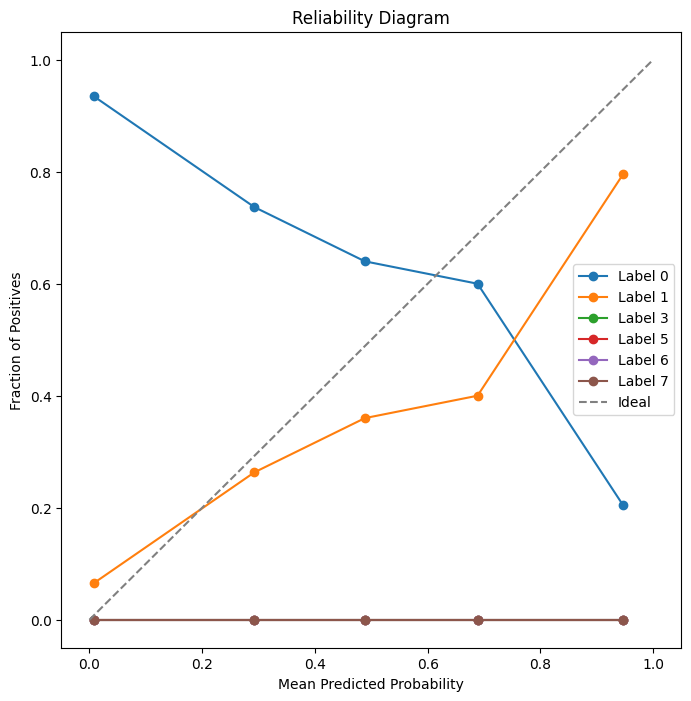

In [20]:
#// BEGIN_TODO [STEP_3] Visualize calibration of uncalibrated model (1 point)

probabilities = model.predict_proba(X_test_flat)[:, 1]
probabilities_train = model.predict_proba(X_train_flat)[:, 1]

# Specify the positive class explicitly
pos_labels = [0, 1, 3, 5, 6, 7]  # Replace with your actual positive class labels

# Create a single reliability diagram
plt.figure(figsize=(8, 8))

for num in pos_labels:
    # Create a reliability diagram for each positive class
    prob_true, prob_pred = calibration_curve(y_binary_test, probabilities, pos_label=num, n_bins=5)

    # Plotting for each positive class
    plt.plot(prob_pred, prob_true, marker='o', label=f'Label {num}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')

# Set labels and title
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')

# Add legend
plt.legend()

# Show the combined plot
plt.show()

In [21]:
observation_uncalibrated = ' '

In [22]:
#// END_TODO [STEP_3]

#### Step 4

Choose a calibration metric and assign its name to a string variable `binary_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `binary_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `binary_metric_decision` (max 400 characters).

In [23]:
#// BEGIN_TODO [STEP_4] Choose a calibration metric (1 point)

binary_metric_choice = "Log Loss"
binary_metric_motivation = ''
binary_metric_decision = ''

In [24]:
#// END_TODO [STEP_4]

#### Step 5

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `binary_metric`.

Measure the calibration error of your model on `X_test` and `y_binary_test` and assign the result to the variable `binary_uncalibrated`.

In [25]:
#// BEGIN_TODO [STEP_5] Implement the calibration metric (1 point)

class LogLoss:
    def __init__(self, epsilon=1e-15):
        self.epsilon = epsilon
        self.log_loss = None

    def score(self, p, y):
        """
        Calculate multi-class log loss.

        Parameters:
        - p: 2D array-like or label indicator matrix
                  (n_samples, n_classes)
                  True labels for each instance.
        - y: 2D array-like
                  (n_samples, n_classes)
                  Predicted probabilities for each class.

        Returns:
        - log_loss: float
                    Multi-class log loss.
        """
        # Ensure inputs are numpy arrays
        p = np.array(p)
        y = np.array(y)

        if len(p.shape) == 1 or p.shape[1] == 1:
            p = label_binarize(p, classes=np.unique(p))

        # Clip predicted probabilities to avoid log(0) issues
        y = np.clip(y, self.epsilon, 1 - self.epsilon)

        # Normalize predicted probabilities to sum to 1 for each instance
        y /= y.sum(keepdims=True)

        # Calculate log loss
        self.log_loss = -np.mean(np.sum(p * np.log(y), axis=1))

        return self.log_loss
    
binary_metric = LogLoss()

binary_uncalibrated = binary_metric.score(y_binary_test,probabilities)
print(binary_uncalibrated)

#testing after Plattsacling (move this from here)
#binary_calibrated_test = binary_metric.score(y_binary_test,platt_prob)
#print(binary_calibrated_test)


#Log loss should be low, it penalizes for predicting wrong with high confidence.


2736.8264497395526


In [26]:
#// END_TODO [STEP_5]

## Calibrate the classifer

#### Step 6

Implement at least two calibration methods. Each calibration method should be a Python class with the following methods:

- `fit(self, p, y)`, where 
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It fits the calibration model and returns a reference to `self`.
- `predict_proba(self, p)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with confidence estimates of the *positive class* for $N$ samples.
    - It returns an `np.ndarray` of shape $[N,]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `binary_calibrators`.

In [48]:
#// BEGIN_TODO [STEP_6] Implement calibration methods (1 point)
from sklearn.utils.validation import check_X_y
from sklearn.linear_model import LogisticRegression
# Calibration method #1: Platt Scaling (assumes binary classification)
class PlattScaling(BaseEstimator,ClassifierMixin):
    def __init__(self):
        self.calibrator = None

    def fit(self,p,y):
        p, y = check_X_y(p.reshape(-1,1),y,accept_sparse=True)

        self.calibrator = LogisticRegression(solver='lbfgs')
        self.calibrator.fit(p,y)

        return self
    

    def predict_proba(self,p):

        return self.calibrator.predict_proba(p.reshape(-1,1)).astype(np.float32)[:,1]




In [51]:
from sklearn.isotonic import IsotonicRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y
import numpy as np

class IsotonicRegressionCalibration(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.calibrator = None

    def fit(self, p, y):
        p, y = check_X_y(p.reshape(-1, 1), y, accept_sparse=True)

        self.calibrator = IsotonicRegression(out_of_bounds='clip')
        self.calibrator.fit(p.ravel(), y)

        return self

    def predict_proba(self, p):
        return self.calibrator.transform(p.ravel()).reshape(-1, 1).astype(np.float32)[:,0]

In [49]:
Platt = PlattScaling()

Platt.fit(probabilities_train,y_binary_train)

platt_prob = Platt.predict_proba(probabilities)
binary_calibrators = [Platt]
platt_prob

array([0.00369033, 0.0035781 , 0.00375887, ..., 0.00371506, 0.00602797,
       0.00358172], dtype=float32)

In [50]:
platt_prob.shape

(2065,)

In [40]:
platt_prob.dtype

dtype('float32')

In [52]:
Iso = IsotonicRegressionCalibration()
Iso.fit(probabilities_train,y_binary_train)
iso_prob = Iso.predict_proba(probabilities)
iso_prob

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [53]:
iso_prob.shape

(2065,)

In [54]:
iso_prob.dtype

dtype('float32')

In [ ]:
#// END_TODO [STEP_6]

#### Step 7

Evaluate the performance of your calibration methods. Describe your observations in the variable `observation_calibrators` (max 2000 characters).

In [ ]:
#// BEGIN_TODO [STEP_7] Evaluate the calibration method (1 point)

binary_uncalibrated = binary_metric.score(y_binary_test,probabilities)
print(f'Uncalibrated LogLoss: {binary_uncalibrated}')

binary_calibrated_test = binary_metric.score(y_binary_test,platt_prob)
print(f'Calibrated LogLoss: {binary_calibrated_test}')

iso_check = binary_metric.score(y_binary_test,iso_prob)
print(f'Calibrated LogLoss: {iso_check}')

#Amazing drop in the log loss, which shows the value of calibration

Uncalibrated LogLoss: 2736.8264497395526
Calibrated LogLoss: 2169.641634107964
Calibrated LogLoss: 2.558120780418341


In [ ]:
observation_calibrators = ' '

In [ ]:
#// END_TODO [STEP_7]

#### Step 8

Let's evaluate your selected calibration method on the output from different classifier, stored in the `./data/wafer_calibration.pkl` pickle file.

In [ ]:
with open('./data/wafer_calibration.pkl', 'rb') as f:
    p_calib_train, p_calib_test, y_calib_train, y_calib_test = pickle.load(f)

`p_calib_train` and `p_calib_test` contain the confidence estimates of a classifier (divided into a training and test set), and `y_calib_train` and `y_calib_test` contain the corresponding true labels.

Retrain your calibration methods on `p_calib_train` and `y_calib_train`. Use `p_calib_test` and `y_calib_test` to evaluate your methods. Describe your observations in the variable `observation_other` (max 800 characters).

In [ ]:
#// BEGIN_TODO [STEP_8] Evaluate the calibration method on another classifier (1 point)

Platt_two = PlattScaling()
Platt_two.fit(p_calib_train,y_calib_train)

platt_prob_two = Platt.predict_proba(p_calib_test)
platt_prob_two


p_calib_LogLoss = binary_metric.score(y_calib_test,platt_prob_two)
print(f'Calibrated LogLoss: {p_calib_LogLoss}')


observation_other = "The log loss score is slightly lower than the log loss score achieved from our binary classifier. This gap can be reduced by increasing the complexity of our classifier."

Calibrated LogLoss: 988.5536002424401


In [ ]:
observation_other = ' '

In [ ]:
#// END_TODO [STEP_8]

#### Step 9

Choose your favorite calibration method. Assign the instantiated class implementing your chosen calibration method to the variable `binary_calibrator` and its name to a string variable `binary_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `binary_calibrator_motivation` (max 800 characters).

Apply the calibration method to the confidence estimates in `p_calib_test` and assign the calibrated confidence estimates to `q_calib_test` (an `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated confidence estimates in `q_calib_test` and assign the result to the variable `binary_calibrated`.

In [ ]:
#// BEGIN_TODO [STEP_9] Choose a calibration method (1 point)

binary_calibrator_choice = "Platt Scaling"
binary_calibrator = IsotonicRegressionCalibration()
binary_calibrator.fit(p_calib_train,y_calib_train)

q_calib_test = binary_calibrator.predict_proba(p_calib_test)
binary_calibrated_64 = binary_metric.score(y_calib_test,q_calib_test)
binary_calibrated = binary_calibrated_64.astype(np.float32)


In [ ]:
binary_calibrator_motivation = ''

In [ ]:
#// END_TODO [STEP_9]

#### Leaderboard (binary)

Your grade for this assignment will be based on your position on two leaderboards, one for binary calibration and one for multi-class calibration. Your submission to the leaderboards will be automatically computed based on this notebook after you submit it to the "Assignment 1: Calibration" assignment on Canvas.

You may submit as many times as you like before the deadline. We will try to update the leaderboard regularily. Your latest submission at the moment the leaderboard is computed will count.

The data for the binary leaderboard is stored in the `./data/wafer_leaderboard_binary.pkl` pickle file.

In [ ]:
with open('./data/wafer_leaderboard_binary.pkl', 'rb') as f:
    p_binary_leaderboard = pickle.load(f)

The data in `p_binary_leaderboard` comes from a similar distribution to the binary calibration data in `./data/wafer_calibration.pkl`.

Apply your `binary_calibrator` to the confidence estimates in `p_binary_leaderboard`. Assign the resulting calibrated confidence esimates to `q_binary_leaderboard`.

Assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to `None`.

In [ ]:
#// BEGIN_TODO [LEADERBOARD_BINARY] Join the leaderboard

q_binary_leaderboard = binary_calibrator.predict_proba(p_binary_leaderboard)
leaderboard_nickname = "Durum Bois"


In [ ]:
#// END_TODO [LEADERBOARD_BINARY]

Run the following cell to create a file with your leaderboard submission.

In [ ]:
if leaderboard_nickname is not None:

    # perform some sanity checks
    assert isinstance(group_number, int), "group_number is not an integer"
    assert isinstance(leaderboard_nickname, str), "leaderboard_nickname is not a string"
    assert isinstance(q_binary_leaderboard, np.ndarray), "q_binary_leaderboard is not an np.ndarray"
    assert q_binary_leaderboard.shape == p_binary_leaderboard.shape, "q_binary_leaderboard has wrong shape"

    # export the solution to a .json file
    with open("leaderboard_binary.json", "w") as file:
            json.dump({
                "group_number": group_number,
                "leaderboard_nickname": leaderboard_nickname,
                "q_binary_leaderboard": q_binary_leaderboard.tolist()
            }, file)

If all went well, a `leaderboard_binary.json` file should have been created in the same directory as this notebook. **Check that it is created, as this file will be used for your leaderboard submission!**

## Extend to multi-class classification

So far we have assumed a binary classification task. In this part you will implement a calibration metric and method that is applicable to multi-class classification.

#### Step 10

For evaluating the multi-class calibration metric and method, train a classifier on the multi-class wafer map data `X_train` and `y_train` that was loaded earlier. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class and the confidence estimate for each class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor.

Evaluate your trained model on the test set `X_test` and `y_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_multiclass_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimates in the variables `multi_uncalibrated_y` and `multi_uncalibrated_p`, respectively:

- `multi_uncalibrated_y` should be a `np.ndarray` of shape $[N,K]$, with the predicted classes (one-hot encoded), where $N$ is the number of samples and $K$ is the number of classes, i.e. `multi_uncalibrated_y[n][k]` is 1 if the classifier predicted class `k`, otherwise it is 0, 
- `multi_uncalibrated_p` should be a `np.ndarray` of shape $[N,K]$, with the corresponding confidence estimates, i.e. `multi_uncalibrated_p[n][k]` is the classifier's confidence that the predicted class should be `k`.

> **IMPORTANT:** For the wafer dataset $K = 9$ and the class indeces should correspond to the classes listed in section **Load the data**.

In [ ]:
#// BEGIN_TODO [STEP_10] Train a multi-class classifier (1 point)



In [ ]:

multi_model = MLPClassifier(solver='adam',alpha=1e-6,hidden_layer_sizes=(16,8,4,2),random_state=10)
multi_model.fit(X_train_flat,y_train)

multi_uncalibrated_y = multi_model.predict(X_test_flat)
multi_uncalibrated_p = multi_model.predict_proba(X_test_flat)


c:\Users\devan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
num_classes_trained = len(multi_model.classes_)

# Number of classes you want in the output
num_classes_desired = 9

# Create an identity matrix for the desired number of classes
identity_matrix = np.eye(num_classes_desired)

# Create a mapping from trained classes to desired classes
class_mapping = {i: i for i in range(num_classes_trained)}

# Extend the identity matrix if there are additional classes


# Convert predicted classes to one-hot encoded format
multi_uncalibrated_y_one_hot = np.array([identity_matrix[class_mapping[label]] for label in multi_uncalibrated_y])


In [ ]:
original_classes = np.array([0, 1, 3, 5, 6, 7])

# Extra classes to be added
extra_classes = np.array([2, 4, 8])

# Combine original and extra classes
all_classes = np.concatenate((original_classes, extra_classes))

# Number of classes in the trained model
num_classes_trained = len(multi_model.classes_)

# Number of classes you want in the output
num_classes_desired = len(all_classes)

# Create an identity matrix for the desired number of classes
identity_matrix = np.eye(num_classes_desired)

# Create a mapping from trained classes to desired classes
class_mapping = {label: idx for idx, label in enumerate(all_classes)}

# Pad the predicted probabilities with zeros for additional classes
multi_uncalibrated_p_padded = np.zeros((len(multi_uncalibrated_p), num_classes_desired))
for i, label in enumerate(multi_model.classes_):
    if label in class_mapping:
        multi_uncalibrated_p_padded[:, class_mapping[label]] = multi_uncalibrated_p[:, i]

In [ ]:
observation_multiclass_classifier = ''

In [ ]:
#// END_TODO [STEP_10]

#### Step 11

Choose a calibration metric and assign your choice to a string variable `multi_calibration_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `multi_calibration_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `multi_calibration_decision` (max 200 characters).

In [ ]:
#// BEGIN_TODO [STEP_11] Choose a multi-class calibration metric (1 point)

# ===== =====> Replace this line by your code. <===== ===== #
multi_calibration_choice = "Log Loss"
multi_calibration_motivation = "Trying same one used in binary classification"
multi_calibration_decision = "The lower the scoret the better"


In [ ]:
#// END_TODO [STEP_11]

#### Step 12

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `multi_metric`.

Measure the calibration error of your model on `X_test` and `y_test` and assign the result to the variable `multi_uncalibrated`.

In [ ]:
#// BEGIN_TODO [STEP_12] Implement the multi-class calibration metric (1 point)


class LogLoss:
    def __init__(self, epsilon=1e-15):
        self.epsilon = epsilon
        self.log_loss = None

    def score(self,y_prob,y_true):
        """
        Calculate multi-class log loss.

        Parameters:
        - y_true: 2D array-like or label indicator matrix
                  (n_samples, n_classes)
                  True labels for each instance.
        - y_prob: 2D array-like
                  (n_samples, n_classes)
                  Predicted probabilities for each class.

        Returns:
        - log_loss: float
                    Multi-class log loss.
        """
        # Ensure inputs are numpy arrays
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)

        

        # Clip predicted probabilities to avoid log(0) issues
        y_prob = np.clip(y_prob, self.epsilon, 1 - self.epsilon)

        # Normalize predicted probabilities to sum to 1 for each instance
        y_prob /= y_prob.sum(keepdims=True)

        # Calculate log loss
        self.log_loss = -np.mean(np.sum(y_true * np.log(y_prob), axis=1))

        return self.log_loss
    
multi_metric = LogLoss()

multi_uncalibrated = multi_metric.score(multi_uncalibrated_p_padded,multi_uncalibrated_y_one_hot)
print(multi_uncalibrated)



7.767471407687902


In [ ]:
#// END_TODO [STEP_12]

#### Step 13

Implement at least one calibration method. Each calibration method should be a Python class with the following methods:

- `fit(self, p, y)`: where 
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It fits the calibration model and returns a reference to `self`.

- `predict_proba(self, p)`: where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - It returns an `np.ndarray` of shape $[N,K]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `multi_calibrators`.

In [ ]:
#// BEGIN_TODO [STEP_13] Implement multi-class calibration methods (1 point)

# Calibration method #1: Platt Scaling (assumes binary classification)
class PlattScaling(BaseEstimator,ClassifierMixin):
    def __init__(self):
        self.calibrator = None

    def fit(self,X,y):
        #X, y = check_X_y(X.reshape(-1,1),y,accept_sparse=True)
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(axis=1)

        self.calibrator = LogisticRegression(solver='lbfgs')
        self.calibrator.fit(X,y)

        return self
    

    def predict_proba(self,X):

        return self.calibrator.predict_proba(X)


In [ ]:
multi_calibrators = [PlattScaling()]




In [ ]:
#// END_TODO [STEP_13]

#### Step 14

Evaluate the performance of your calibration methods. Assign the instantiated class implementing your chosen calibration method to the variable `multiclass_calibrator` and its name to a string variable `multiclass_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `multiclass_calibrator_motivation` (max 800 characters).

Apply the chosen calibration method to your model on the test data `X_test` and assign the calibrated confidence estimates to `q_multi_test` (an `np.ndarray` of shape $[N,K]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated model and assign the result to the variable `multi_calibrated`.

In [ ]:
#// BEGIN_TODO [STEP_14] Choose a multi-class calibration method (1 point)

multiclass_calibrator = PlattScaling()
multiclass_calibrator_choice = ''
multiclass_calibrator_motivation = ''

multiclass_calibrator.fit(multi_uncalibrated_p_padded,y_test)
q_multi_test = multiclass_calibrator.predict_proba(multi_uncalibrated_p_padded)



ValueError: Found input variables with inconsistent numbers of samples: [18585, 2065]

In [ ]:
multi_calibrated = multi_metric.score(y_test_one_hot,q_multi_test)
multi_calibrated
#score has increased, need to change the calibration metric and adapt for multiclass most likely

13.96314371721348

In [ ]:
#// END_TODO [STEP_14]

#### Multi-class leaderboard

The `./data/wafer_leaderboard_multiclass.pkl` pickle file contains the data that you can use for training your `multiclass_calibrator`, and the data for computing your submission to the leaderboard data.

In [ ]:
with open('./data/wafer_leaderboard_multiclass.pkl', 'rb') as f:
    p_multiclass_leaderboard_train, y_multiclass_leaderboard_train, p_multiclass_leaderboard = pickle.load(f)

Train your `multiclass_calibrator` on the confidence estimates in `p_multiclass_leaderboard_train` and the corresponding true class labels in `y_multiclass_leaderboard_train`.

Apply your `multiclass_calibrator` to the confidence estimates in `p_multiclass_leaderboard`. Assign the resulting calibrated confidence esimates to `q_multiclass_leaderboard`.

Assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to `None`.

In [ ]:
#// BEGIN_TODO [LEADERBOARD_MULTICLASS] Join the leaderboard
multiclass_calibrator.fit(p_multiclass_leaderboard_train,y_multiclass_leaderboard_train)
q_multiclass_leaderboard = multiclass_calibrator.predict_proba(p_multiclass_leaderboard)
leaderboard_nickname = 'Big Durum Bois'


In [ ]:
print(p_multiclass_leaderboard.shape)
print(p_multiclass_leaderboard_train.shape)
print(y_multiclass_leaderboard_train.shape)

(1040, 9)
(1040, 9)
(1040,)


In [ ]:
q_multiclass_leaderboard.shape

(1040, 6)

In [ ]:
#// END_TODO [LEADERBOARD_MULTICLASS]

Run the following cell to create a file with your leaderboard submission.

In [ ]:
if leaderboard_nickname is not None:
    
    # perform some sanity checks
    assert isinstance(group_number, int), "group_number is not an integer"
    assert isinstance(leaderboard_nickname, str), "leaderboard_nickname is not a string"
    assert isinstance(q_multiclass_leaderboard, np.ndarray), "q_multiclass_leaderboard is not an np.ndarray"
    assert q_multiclass_leaderboard.shape == p_multiclass_leaderboard.shape, "q_multiclass_leaderboard has wrong shape"

    # export the solution to a .json file
    with open("leaderboard_multiclass.json", "w") as file:
        json.dump({
            "group_number": group_number,
            "leaderboard_nickname": leaderboard_nickname,
            "q_multiclass_leaderboard": q_multiclass_leaderboard.tolist()
        }, file)

AssertionError: q_multiclass_leaderboard has wrong shape

If all went well, a `leaderboard_multiclass.json` file should have been created in the same directory as this notebook.  **Check that it is created, as this file will be used for your leaderboard submission!**

#### Step 15

A well calibrated classifier can also be used to identify whether a test sample is out-of-distribution, i.e. if it is very different from the data that the classifier was trained on. The `ood.pkl` file contains several out-of-distribution samples.

In [ ]:
with open('./data/ood.pkl', 'rb') as f:
    X_ood = pickle.load(f)
    
plt.imshow(X_ood[0]);

Evaluate your classifier and calibration method on the data in `X_ood`. Describe your observations in a string variable `observation_ood` (max 1000 characters). Describe one drawback of this approach for identifying out-of-distribution samples in a string variable `drawback_ood` (max 500 characters).

In [ ]:
#// BEGIN_TODO [STEP_15] (1 point)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_15]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`. Please fill in the average among all group members.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]

import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult. Please fill in the average among all group members.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)

#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### Which Machine Learning-related courses did you complete (TUE/workshop/online/etc.)?

Assign a string to variable `feedback_courses`, listing any ML courses any of your group members followed.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 points)

#// END_FEEDBACK [Feedback_3]

assert isinstance(feedback_courses, str), "Please assign a string to variable feedback_courses"

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 points)

#// END_FEEDBACK [Feedback_4]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]